In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
import datetime
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm, probplot
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from arch.unitroot import VarianceRatio
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller 
from scipy.stats import genpareto
from sklearn.utils import resample
from scipy.optimize import minimize
from scipy.special import expit, logit
from sklearn.linear_model import LogisticRegression
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from scipy.optimize import minimize
from scipy.stats import genpareto
from scipy.optimize import differential_evolution
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from scipy.optimize import differential_evolution
from scipy.stats import gumbel_r
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
import ta
import shap
from xgboost.callback import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Import Data

In [6]:
btc_min_return = pd.read_csv('btc_min_return_selected.csv')
btc_min_return.index =pd.to_datetime(btc_min_return['timestamp'])
btc_min_return.drop(columns=['timestamp'],inplace=True)
btc_min_return.columns

In [14]:
# Create the target variable -- Quantile based threshold
upper_quantile = btc_min_return['return'].quantile(0.7)
lower_quantile = btc_min_return['return'].quantile(0.3)
btc_min_return['target'] = 0
btc_min_return.loc[btc_min_return['return'].shift(-1) > upper_quantile, 'target'] = 1
btc_min_return.loc[btc_min_return['return'].shift(-1) < lower_quantile, 'target'] = -1
btc_min_return = btc_min_return.dropna()

# Create the target variable -- Momentum based threshold
short_window = 40
long_window = 100
btc_min_return['short_mavg'] = btc_min_return['return'].rolling(window=short_window, min_periods=1, center=False).mean()
btc_min_return['long_mavg'] = btc_min_return['return'].rolling(window=long_window, min_periods=1, center=False).mean()
btc_min_return['target_momentum'] = 0
btc_min_return.loc[(btc_min_return['short_mavg'].shift(-1) > btc_min_return['long_mavg'].shift(-1)) & (btc_min_return['return'].shift(-1)>0), 'target_momentum'] = 1
btc_min_return.loc[(btc_min_return['short_mavg'].shift(-1) < btc_min_return['long_mavg'].shift(-1)) & (btc_min_return['return'].shift(-1)<0), 'target_momentum'] = -1
btc_min_return = btc_min_return.dropna()

In [20]:
# Define features and target variable
features = btc_min_return.columns.to_list()
features.remove('return')
features.remove('target')
features.remove('target_momentum')
features.remove('short_mavg')
features.remove('long_mavg')

features_reduced = features[:6]+features[-17:]

### Feature Selection

In [22]:
df = btc_min_return.copy()
X = df[features]
y = df['target']

# Split the data into training and test sets
cutoff_date = '2022-01-01'
X_train = X[X.index < cutoff_date]
X_test = X[X.index >= cutoff_date]
y_train = y[X.index < cutoff_date]
y_test = y[X.index >= cutoff_date]

# Scale the features -- without stochastic features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


features_reduced = features[:6]+features[-17:]
X_reduced = df[features_reduced]

# Split the data into training and test sets
cutoff_date = '2022-01-01'
X_train_reduced = X_reduced[X_reduced.index < cutoff_date]
X_test_reduced = X_reduced[X_reduced.index >= cutoff_date]

scaler = StandardScaler()
X_train_reduced = scaler.fit_transform(X_train_reduced)
X_test_reduced = scaler.transform(X_test_reduced)

In [136]:
train_start_date = '2022-01-01'
train_end_date = '2022-12-31'
test_start_date = '2023-01-01'

X_train_subset = X[(X.index >= train_start_date) & (X.index <= train_end_date)]
X_test_subset = X[(X.index >= test_start_date) ]
y_train_subset = y[(y.index >= train_start_date) & (y.index <= train_end_date)]
y_test_subset = y[(y.index >= test_start_date) ]

scaler = StandardScaler()
X_train_subset = scaler.fit_transform(X_train_subset)
X_test_subset = scaler.transform(X_test_subset)

X_train_subset_reduced = X_reduced[(X_reduced.index >= train_start_date) & (X_reduced.index <= train_end_date)]
X_test_subset_reduced = X_reduced[(X_reduced.index >= test_start_date) ]

scaler_reduced = StandardScaler()
X_train_subset_reduced = scaler_reduced.fit_transform(X_train_subset_reduced)
X_test_subset_reduced = scaler_reduced.transform(X_test_subset_reduced)




In [132]:
# Custom accuracy function
def custom_accuracy(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    true_neg = conf_matrix[0, 0]
    true_pos = conf_matrix[2, 2]
    neutral_pred_as_neg = conf_matrix[1, 0]
    neutral_pred_as_pos = conf_matrix[1, 2]
    neg_pred_as_pos = conf_matrix[0, 2]
    pos_pred_as_neg = conf_matrix[2, 0]
    total = conf_matrix.sum()
    custom_acc = (true_neg + true_pos) / (total - (neutral_pred_as_neg + neutral_pred_as_pos + neg_pred_as_pos + pos_pred_as_neg))
    return custom_acc

#### Benchmark model: Linear regression

In [142]:
upper_quantile = btc_min_return['return'].quantile(0.7)
lower_quantile = btc_min_return['return'].quantile(0.3)

def convert_to_classes(predictions, lower_threshold, upper_threshold):
    y_pred_class = np.where(predictions >= upper_threshold, 1,
                            np.where(predictions <= lower_threshold, -1, 0))
    return y_pred_class

              precision    recall  f1-score        support
-1             0.242342  0.541994  0.334928   65366.000000
0              0.660792  0.015669  0.030612  174674.000000
1              0.201409  0.475334  0.282934   65960.000000
accuracy       0.227183  0.227183  0.227183       0.227183
macro avg      0.368181  0.344332  0.216158  306000.000000
weighted avg   0.472383  0.227183  0.150008  306000.000000
Custom Accuracy: 0.94


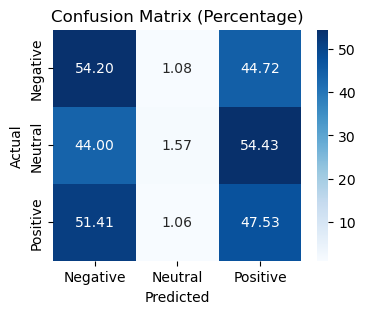

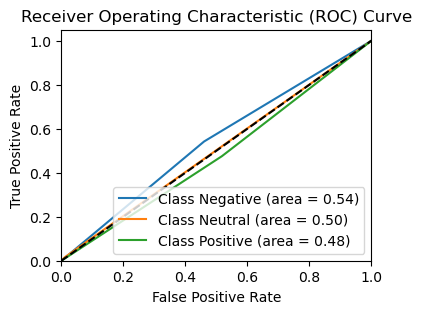

In [146]:
model = LinearRegression()
model.fit(X_train_subset, y_train_subset)

y_pred_subset_continuous = model.predict(X_test_subset)
y_pred_subset = convert_to_classes(y_pred_subset_continuous, lower_quantile, upper_quantile)

report_dict = classification_report(y_test_subset, y_pred_subset, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print(report_df)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_subset, y_pred_subset)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

custom_acc = custom_accuracy(y_test_subset, y_pred_subset)
print(f'Custom Accuracy: {custom_acc:.2f}')

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()

# Compute ROC curve and ROC area for each class
y_test_bin = label_binarize(y_test_subset, classes=[-1, 0, 1])
y_pred_prob = np.zeros_like(y_test_bin, dtype=float)
y_pred_prob[:, 0] = (y_pred_subset == -1).astype(float)
y_pred_prob[:, 1] = (y_pred_subset == 0).astype(float)
y_pred_prob[:, 2] = (y_pred_subset == 1).astype(float)

fpr = dict()
tpr = dict()
roc_auc = dict()
class_names = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}

for i, class_label in enumerate(class_names):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])

# Plot ROC curve
plt.figure(figsize=(4, 3))
for i, class_label in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[class_label]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### Without Stochastic Features

              precision    recall  f1-score        support
-1             0.253163  0.515130  0.339485   65366.000000
0              0.641505  0.017078  0.033269  174674.000000
1              0.197268  0.503472  0.283468   65960.000000
accuracy       0.228314  0.228314  0.228314       0.228314
macro avg      0.363979  0.345227  0.218741  306000.000000
weighted avg   0.462792  0.228314  0.152613  306000.000000
Custom Accuracy: 0.93


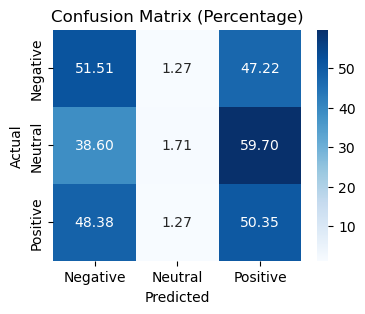

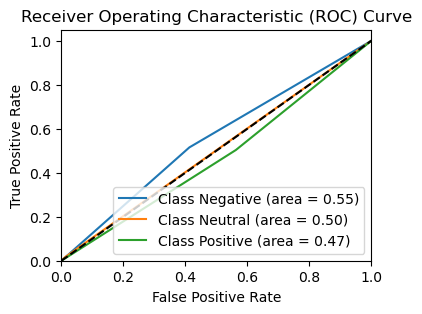

In [152]:
model = LinearRegression()
model.fit(X_train_subset_reduced, y_train_subset)

y_pred_subset_continuous = model.predict(X_test_subset_reduced)
y_pred_subset_reduced = convert_to_classes(y_pred_subset_continuous, lower_quantile, upper_quantile)

report_dict = classification_report(y_test_subset, y_pred_subset_reduced, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print(report_df)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_subset, y_pred_subset_reduced)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

custom_acc = custom_accuracy(y_test_subset, y_pred_subset_reduced)
print(f'Custom Accuracy: {custom_acc:.2f}')

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()

# Compute ROC curve and ROC area for each class
y_test_bin = label_binarize(y_test_subset, classes=[-1, 0, 1])
y_pred_prob = np.zeros_like(y_test_bin, dtype=float)
y_pred_prob[:, 0] = (y_pred_subset_reduced == -1).astype(float)
y_pred_prob[:, 1] = (y_pred_subset_reduced == 0).astype(float)
y_pred_prob[:, 2] = (y_pred_subset_reduced == 1).astype(float)

fpr = dict()
tpr = dict()
roc_auc = dict()
class_names = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}

for i, class_label in enumerate(class_names):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])

# Plot ROC curve
plt.figure(figsize=(4, 3))
for i, class_label in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[class_label]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Benchmark model: Logistic Regression

##### Full Set of Features

Custom Accuracy: 0.05


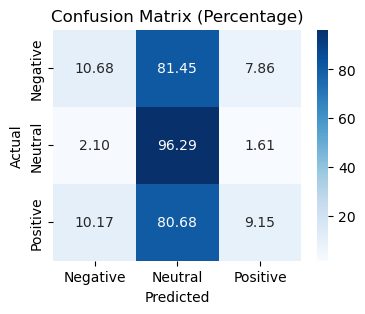

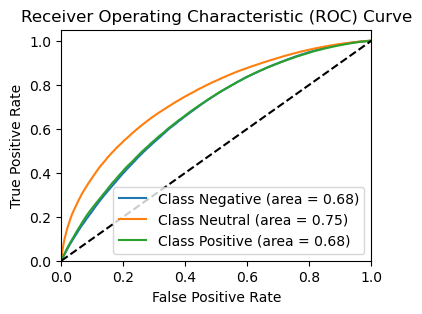

In [133]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)
model.fit(X_train_subset, y_train_subset)

y_pred_subset = model.predict(X_test_subset)

report_dict = classification_report(y_test_subset, y_pred_subset, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

conf_matrix = confusion_matrix(y_test_subset, y_pred_subset)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

custom_acc = custom_accuracy(y_test_subset, y_pred_subset)
print(f'Custom Accuracy: {custom_acc:.2f}')

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()

y_test_bin = label_binarize(y_test_subset, classes=[-1, 0, 1])
y_pred_prob = model.predict_proba(X_test_subset)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
class_names = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}

for i, class_label in enumerate(class_names):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])

# Plot ROC curve
plt.figure(figsize=(4, 3))
for i, class_label in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[class_label]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### Without Stochastic Features

Custom Accuracy: 0.05


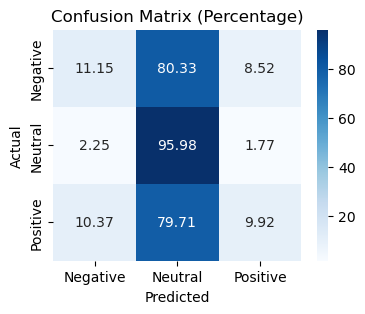

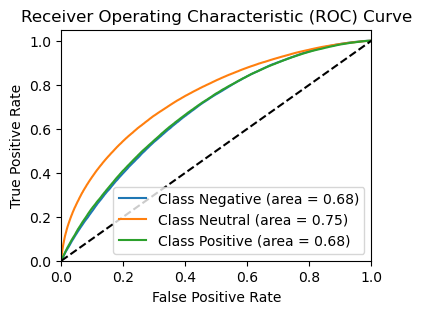

In [134]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)
model.fit(X_train_subset_reduced, y_train_subset)

y_pred_subset_reduced = model.predict(X_test_subset_reduced)

report_dict = classification_report(y_test_subset, y_pred_subset_reduced, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

conf_matrix = confusion_matrix(y_test_subset, y_pred_subset_reduced)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

custom_acc = custom_accuracy(y_test_subset, y_pred_subset_reduced)
print(f'Custom Accuracy: {custom_acc:.2f}')

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()

y_test_bin = label_binarize(y_test_subset, classes=[-1, 0, 1])
y_pred_prob_reduced = model.predict_proba(X_test_subset_reduced)

# Compute ROC curve and ROC area for each class
fpr_reduced = dict()
tpr_reduced = dict()
roc_auc_reduced = dict()
class_names = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}

for i, class_label in enumerate(class_names):
    fpr_reduced[i], tpr_reduced[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob_reduced[:, i])
    roc_auc_reduced[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob_reduced[:, i])

# Plot ROC curve
plt.figure(figsize=(4, 3))
for i, class_label in enumerate(class_names):
    plt.plot(fpr_reduced[i], tpr_reduced[i], label=f'Class {class_names[class_label]} (area = {roc_auc_reduced[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### LSTM model

In [ ]:
X_train

,open,high,low,number_of_trades,close,volume,jump_detected_1_3,jump_size_1_3,jump_detected_2_3,jump_size_2_3,...,return_lag_15min,return_volume_interaction,ema_return_5min,hist_vol_5min,macd,macd_signal,rsi,bollinger_hband,bollinger_lband,atr
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-05-20 04:43:00,39192.41,39266.97,39187.97,0.652779,39239.12,0.485435,0,0.0,0,0.0,...,-0.001968,0.000578,0.000008,0.001998,-0.000158,-0.000347,52.260419,0.002809,-0.003894,90.481172
2020-07-02 06:38:00,9194.59,9195.42,9190.13,-0.422878,9194.68,-0.215267,0,0.0,0,0.0,...,-0.000220,-0.000002,-0.000047,0.000206,-0.000009,0.000001,50.428945,0.000687,-0.000763,4.427139
2023-04-03 02:44:00,27788.00,27788.01,27775.20,-0.248077,27782.72,-0.290420,0,0.0,0,0.0,...,-0.000759,0.000055,-0.000087,0.000126,-0.000022,0.000016,48.426033,0.001134,-0.001057,13.639306
2020-06-05 15:04:00,9682.77,9683.74,9674.17,-0.194376,9680.46,-0.072206,0,0.0,0,0.0,...,0.000320,0.000012,-0.000160,0.000271,-0.000028,-0.000030,49.546127,0.000675,-0.000978,7.634905
2022-08-16 01:00:00,24124.80,24149.53,24123.10,1.877483,24136.40,0.914235,0,0.0,0,0.0,...,-0.000599,0.000439,0.000151,0.000352,-0.000008,-0.000010,52.010266,0.001197,-0.000818,18.161460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-02 19:44:00,19068.25,19075.00,19064.55,-0.302326,19072.64,-0.237864,0,0.0,0,0.0,...,0.000229,-0.000055,0.000162,0.000575,0.000054,0.000083,50.424444,0.001264,-0.000893,15.603749
2022-03-09 13:16:00,41947.73,41947.73,41900.47,0.099881,41902.89,0.280862,0,0.0,0,0.0,...,-0.000689,-0.000300,-0.000204,0.000753,0.000015,0.000081,46.053586,0.001376,-0.001467,37.543410
2021-12-11 04:30:00,48339.26,48379.68,48326.90,-0.372465,48326.90,-0.433633,0,0.0,0,0.0,...,-0.000884,0.000111,-0.000192,0.000666,-0.000037,-0.000014,49.162487,0.001052,-0.001331,36.318232


In [85]:
timesteps = 10  # Number of time steps
n_features = X_train.shape[1]  # Number of features

# Function to create sequences
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:(i + timesteps)])
        ys.append(y[i + timesteps])
    return np.array(Xs), np.array(ys)

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train.to_numpy(), y_encoded, timesteps)

# Split the data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_seq, y_train_seq, test_size=0.2, random_state=42)

# Build the autoencoder model
input_dim = X_train_seq.shape[2]

# Encoder
encoder_input = tf.keras.layers.Input(shape=(input_dim,))
encoder_output = tf.keras.layers.Dense(32, activation='relu')(encoder_input)
encoder_output = tf.keras.layers.Dense(16, activation='relu')(encoder_output)

# Decoder
decoder_output = tf.keras.layers.Dense(32, activation='relu')(encoder_output)
decoder_output = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoder_output)

# Autoencoder
autoencoder = tf.keras.Model(encoder_input, decoder_output)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
X_train_flat = X_train_split.reshape(-1, input_dim)
X_val_flat = X_val_split.reshape(-1, input_dim)
autoencoder.fit(X_train_flat, X_train_flat, epochs=10, batch_size=32, validation_data=(X_val_flat, X_val_flat))

# Extract the encoder model
encoder = tf.keras.Model(encoder_input, encoder_output)

# Transform the data using the encoder
X_train_encoded = encoder.predict(X_train_flat).reshape(X_train_split.shape[0], timesteps, -1)
X_val_encoded = encoder.predict(X_val_flat).reshape(X_val_split.shape[0], timesteps, -1)

# Build and train the LSTM model using the encoded data
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(timesteps, X_train_encoded.shape[2])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train_encoded, y_train_split, epochs=10, batch_size=32, validation_data=(X_val_encoded, y_val_split), callbacks=[early_stopping])

# Use a larger subset of the data for SHAP values to avoid memory issues
subset_size = 1000  # Increase this based on your memory constraints
X_train_subset = X_train.sample(subset_size, random_state=42)
X_train_subset_seq, y_train_subset_seq = create_sequences(X_train_subset.to_numpy(), y_encoded[:len(X_train_subset)], timesteps)

# Transform the subset using the encoder
X_train_subset_flat = X_train_subset_seq.reshape(-1, input_dim)
X_train_subset_encoded = encoder.predict(X_train_subset_flat).reshape(X_train_subset_seq.shape[0], timesteps, -1)

'''# SHAP analysis
explainer = shap.DeepExplainer(model, X_train_subset_encoded)
shap_values = explainer.shap_values(X_train_subset_encoded)

# Summary plot
shap.summary_plot(shap_values, X_train_subset_encoded, feature_names=X_train.columns)

# Dependence plot for a specific feature
shap.dependence_plot("specific_feature_name", shap_values[0], X_train_subset_encoded)'''


Epoch 1/10
618128/618128 [==============================] - 477s 767us/step - loss: 66858684.0000 - val_loss: 66832632.0000
Epoch 2/10
618128/618128 [==============================] - 462s 748us/step - loss: 66857664.0000 - val_loss: 66832632.0000
Epoch 3/10
618128/618128 [==============================] - 461s 747us/step - loss: 66859268.0000 - val_loss: 66832632.0000
Epoch 4/10
618128/618128 [==============================] - 456s 738us/step - loss: 66857936.0000 - val_loss: 66832632.0000
Epoch 5/10
618128/618128 [==============================] - 469s 758us/step - loss: 66858052.0000 - val_loss: 66832632.0000
Epoch 6/10
618128/618128 [==============================] - 455s 737us/step - loss: 66857928.0000 - val_loss: 66832632.0000
Epoch 7/10
618128/618128 [==============================] - 466s 754us/step - loss: 66857992.0000 - val_loss: 66832632.0000
Epoch 8/10
618128/618128 [==============================] - 456s 738us/step - loss: 66858548.0000 - val_loss: 66832632.0000
Epoch 9/

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/xiaoyuxu/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/19/k469sb1515992nqkpyhjq0pm0000gn/T/ipykernel_72801/3564176685.py", line 78, in <module>
    shap_values = explainer.shap_values(X_train_subset_encoded)
  File "/Users/xiaoyuxu/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/shap/explainers/_deep/__init__.py", line 125, in shap_values
    return self.explainer.shap_values(X, ranked_outputs, output_rank_order, check_additivity=check_additivity)
  File "/Users/xiaoyuxu/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/shap/explainers/_deep/deep_tf.py", line 313, in shap_values
    sample_phis = self.run(self.phi_symbolic(feature_ind), self.model_inputs, joint_input)
  File "/Users/xiaoyuxu/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/shap/explainers/_deep/deep_tf.py", line 364, in 

15454/15454 [==============================] - 18s 1ms/step
Validation Accuracy: 0.4796128638248908
15454/15454 [==============================] - 18s 1ms/step
Validation ROC AUC: 0.5


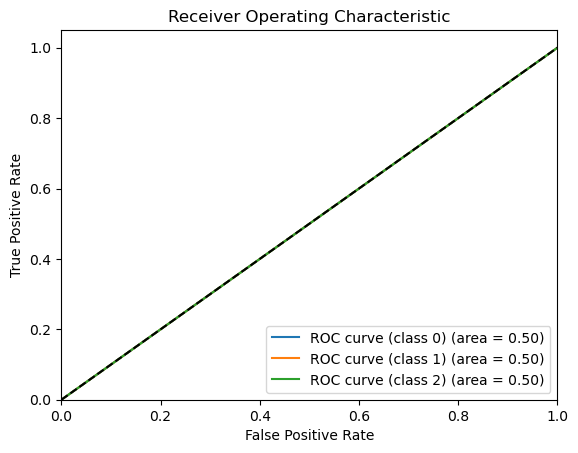

In [94]:
# Compute accuracy and ROC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

y_val_pred = np.argmax(model.predict(X_val_encoded), axis=1)
accuracy = accuracy_score(y_val_split, y_val_pred)
print(f'Validation Accuracy: {accuracy}')

# Compute ROC AUC
y_val_prob = model.predict(X_val_encoded)
roc_auc = roc_auc_score(y_val_split, y_val_prob, multi_class='ovr')
print(f'Validation ROC AUC: {roc_auc}')

# Plot ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

n_classes = len(np.unique(y_encoded))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_split, y_val_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()